## 量子プログラミング入門：TKET 編

Kentaro Yamamoto (Research Scientist)

**Cambridge Quantum Computing Japan**

kentaro.yamamoto@cambridgequantum.com

### Overview

In this webinar, we will provide demos on `pytket` and `qermit`, both of which are open-source Python libraries developed by Cambridge Quantum.
`pytket` is a Python interface to TKET --- platform-agnostic quantum software development kit (QSDK), wheras `qermit` is a quantum error mitigation framework integrated with `pytket`.
Examples are taken from quantum chemistry problems, but the codes are available for general purposes.
By using `pytket` and `qermit`, **one can quickly prototype and run the platform-agnostic quantum programs.**

### Why TKET?

How does pytket satisfy the constraints of NISQ-era quantum computers?

* A Generic Compilation Strategy for the Unitary Coupled Cluster Ansatz &rightarrow; **arXiv:2007.10515** <br>
* t|ket$\rangle$: A Retargetable Compiler for NISQ Devices &rightarrow; **arXiv:2003.10611** <br>
* Phase Gadget Synthesis for Shallow Circuits &rightarrow; **arXiv:1906.01734** <br>
* On the qubit routing problem &rightarrow; **arXiv:1902.08091** <br>

[github.com/CQCL/pytket](https://github.com/CQCL/pytket)

### Required python packages

Please install the packages
```
pytket          # Quantum circuit construction
pytket-qiskit   # Quantum circuit compilation
qermit          # Quantum circuit execution (from CQCL/qermit)
```
If these packages are not installed in your environment yet, uncomment the following cell and install them.

In [1]:
#!pip install pytket==0.15.0
#!pip install pytket-qiskit==0.18.0
#!pip install qermit==0.1.2

Version numbers are specified to make sure this script works,
but in general it is recommended to install the latest versions.

[Getting started with Qiskit](https://qiskit.org/documentation/getting_started.html) would be helpful for users who are not familiar with setting up Python environment, including the IBM Quantum account setup to access IBM's hardware used in the following examples.

### TKET Walled Garden: Playing with retargetability 

In [2]:
# Preparing backends
from pytket.extensions.qiskit import IBMQBackend, IBMQEmulatorBackend, AerBackend

device_id = 'ibmq_quito'
# backend = IBMQBackend(device_id)
backend = IBMQEmulatorBackend(device_id)
noiseless_backend = AerBackend()

Construct a quantum circuit for a Bell pair $|\psi\rangle = \frac{1}{2}(|00\rangle + |11\rangle)$ as a `pytket` object.

In [3]:
# Generate quantum circuit.
from pytket import Circuit

bell_circuit = Circuit(2,2).H(0).CX(0,1).measure_all()

In [4]:
from pytket.circuit.display import render_circuit_jupyter

render_circuit_jupyter(bell_circuit)

Retargeting: `pytket` $\to$ `Qiskit`

In [5]:
# Display the quantum circuit using Qiskit.
from pytket.extensions.qiskit import tk_to_qiskit

qisk_c = tk_to_qiskit(bell_circuit)
print(type(qisk_c))
print(qisk_c)

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
     ┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1 


Compile the circuit for a given backend.

In [6]:
# Compile quantum circuit for the IBM devices.
backend.compile_circuit(bell_circuit)

qisk_c = tk_to_qiskit(bell_circuit)
print(qisk_c)

                                          
node_0: ──────────────────────────────────
        ┌────┐┌─────────┐┌────┐     ┌─┐   
node_1: ┤ √X ├┤ Rz(π/2) ├┤ √X ├──■──┤M├───
        └────┘└─────────┘└────┘┌─┴─┐└╥┘┌─┐
node_2: ───────────────────────┤ X ├─╫─┤M├
                               └───┘ ║ └╥┘
   c: 2/═════════════════════════════╩══╩═
                                     0  1 


Retargeting: `pytket` $\to$ `OpenQASM`

In [7]:
# Convert the circuit into OpenQASM format.
from pytket.qasm import circuit_to_qasm_str

qasm_c = circuit_to_qasm_str(bell_circuit)
print(qasm_c)

OPENQASM 2.0;
include "qelib1.inc";

qreg node[3];
creg c[2];
sx node[1];
rz(0.5*pi) node[1];
sx node[1];
cx node[1],node[2];
measure node[1] -> c[0];
measure node[2] -> c[1];



In [8]:
# Convert the circuit from OpenQASM format.
from pytket.qasm import circuit_from_qasm_str
render_circuit_jupyter(circuit_from_qasm_str(qasm_c))

Make a measurement with the given backend.

In [9]:
# Execute quantum circuit.
handle = backend.process_circuit(bell_circuit, n_shots=1000)
result = backend.get_result(handle)

# Check the shot counts.
print(result.get_counts())

Counter({(0, 0): 487, (1, 1): 476, (0, 1): 20, (1, 0): 17})


### Leaving the Walled Garden via VQE

It is widely believed that a variational (hybrid quantum-classical) algorithm
is a promising approach to attain quantum advantage with NISQ devices.
In the variational algorithm,
heavy tasks such as expectation value evaluation are performed by quantum computers,
while the other tasks are handled by classical computers to drive a feedback loop.

Variational quantum eigensolver (VQE) is one of the most frequently used
variational algorithms.
In the VQE algorithm,
we consider a cost function $E(\boldsymbol{\theta})$
depending on a set of
parameters $\boldsymbol{\theta}$
describing an associated trial wavefunction $|\Psi(\boldsymbol{\theta})\rangle$,
which is expressed as

$$
    E(\boldsymbol{\theta})
    =
    \langle
        \Psi(\boldsymbol{\theta}) | \hat{H} | \Psi(\boldsymbol{\theta})
    \rangle
$$

where $\hat{H}$ is a Hamiltonian describing the system.
The trial wavefunction $|\Psi(\boldsymbol{\theta})\rangle$ is actually implemented
into the quantum computer in the following form

$$
    |\Psi(\boldsymbol{\theta})\rangle
    =
    \hat{U}(\boldsymbol{\theta}) |\Psi_{0}\rangle
$$

where $|\Psi_{0}\rangle$ corresponds to an initial state that should be
easily prepared.
The unitary operator $\hat{U}(\boldsymbol{\theta})$ is implemented as
a parameterized quantum circuit,
or ansatz.
The Hamiltonian $\hat{H}$ is usually transformed into a series of $k$-local operators such as Pauli strings (tensor product of qubit local Pauli operator)
$\{\hat{P}_{a}\}$

$$
    \hat{H} = \sum_{a}h_{a}\hat{P}_{a}
$$

where $\{h_{a}\}$ is a set of coefficients, each of which is complex valued in general.
Thus by evaluating $\langle \Psi(\boldsymbol{\theta})|\hat{P}_{a}|\Psi(\boldsymbol{\theta})\rangle$
for all $a$, 
$E(\boldsymbol{\theta})$ can be evaluated.

In summary, to perform VQE algorithm, we need the following quantities:

* $\hat{H}=\sum_{a}h_{a}\hat{P}_{a}$: Hamiltonian (qubit Pauli operator)
* $|\Psi(\boldsymbol{\theta})\rangle = \hat{U}(\boldsymbol{\theta}) |\Psi_{0}\rangle$: Ansatz (parametrized quantum circuit)

#### Hamiltonian operator as a `QubitPauliOperator`

In the examples below, we use Hamiltonian coming from quantum chemistry problems.
The qubit Hamiltonian was preliminary calculatied with 
[EUMEN](https://cqcl.github.io/eumen/build/html/index.html), a proprietary quantum computational chemistry packaged developed by Cambridge Quantum.
The hard-coded qubit Pauli operator below is generated from a fermionic Hamiltonian in the Hartree-Fock molecular orbital (MO) basis using Jordan-Wigner transformation.
Here the MOs are calculated for a hydrogen molecule (the H-H distance is set to 0.735 Å) with STO-3G basis set.
Qubit tapering by exploiting symmetry (alpha- and beta-spin particle number conservation) is applied to obtain a two qubit model system.

In [10]:
# Prepare a qubit Hamiltonian in the direct (second-quantized) mapping.
from pytket.circuit import Qubit
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator

n_qubits = 2

qubits = [Qubit(i) for i in range(n_qubits)]
qpo_identity = -0.3324042513238792
qpo_dict = {
    QubitPauliString([qubits[0]], [Pauli.Z]): -0.39793742484318023,
    QubitPauliString([qubits[1]], [Pauli.Z]): -0.39793742484318023,                                                 
    QubitPauliString([qubits[0], qubits[1]], [Pauli.Z, Pauli.Z]): 0.011280104256235296,
    QubitPauliString([qubits[0], qubits[1]], [Pauli.Y, Pauli.Y]): -0.18093119978423144,
}
operator = QubitPauliOperator(qpo_dict)
for k, v in operator._dict.items():
    print(f'{v:8.4f} {k}')

 -0.3979 (Zq[0])
 -0.3979 (Zq[1])
  0.0113 (Zq[0], Zq[1])
 -0.1809 (Yq[0], Yq[1])


In [11]:
# Some reference energy values
hf_energy = -1.116998996754
cc_energy = -1.137306035759

####  Ansatz as a symbolic `Circuit` and circuit optimization with TKET

In some chemistry-motivated ansatzes such as unitary coupled cluster (UCC),
a Pauli exponential $e^{i\theta_{m}\hat{P}_{m}}$ is a building block as
$$
    \hat{U}(\boldsymbol{\theta}) = \prod_{m}e^{i\theta_{m}\hat{P}_{m}}
$$
There is a general recipe to efficiently implement a Pauli exponential to a circuit, which is called Pauli gadget.
`pytket` provides an easy way to construct a pauli gadget as shown below:

In [12]:
from pytket.circuit import PauliExpBox, fresh_symbol, OpType
from pytket.passes import DecomposeBoxes

box = PauliExpBox([Pauli.I, Pauli.Z, Pauli.X, Pauli.Y], fresh_symbol('tm'))
circ = Circuit(4)
circ.add_pauliexpbox(box, circ.qubits)
DecomposeBoxes().apply(circ)
render_circuit_jupyter(circ)

In NISQ era, it is important to reduce the circuit depth.
`pytket` has various compilation passes to perform circuit optimization.
In the following example we optimize a large pauli gadgets by using `pytket.PauliSimp`. 

In [13]:
import numpy as np

def get_random_pauli_gadgets(n_qubits, n_pauli_gadgets, max_entangle):
    """ """
    paulis = [Pauli.I, Pauli.X, Pauli.Y, Pauli.Z]
    circ = Circuit(n_qubits)
    for i in range(n_pauli_gadgets):
        ls_paulis = [np.random.choice(paulis) for k in range(max_entangle)]
        if ls_paulis.count(Pauli.Y) % 2 == 0:
            continue
        if len(ls_paulis) - ls_paulis.count(Pauli.I) <= 1:
            continue
        # print(ls_paulis)
        qubits = np.random.choice(
            [i for i in range(n_qubits)], size=max_entangle, replace=False
        )
        box = PauliExpBox(ls_paulis, fresh_symbol('x'))
        circ.add_pauliexpbox(box, sorted(qubits))
    DecomposeBoxes().apply(circ)
    return circ

circ = get_random_pauli_gadgets(
    n_qubits=12, n_pauli_gadgets=500, max_entangle=8
)
print('Circuit depth:', circ.depth())
print('CX depth:     ', circ.depth_by_type(OpType.CX))
# render_circuit_jupyter(circ)

Circuit depth: 3017
CX depth:      2417


Now apply the compiler pass to optimize the circuit.

In [14]:
# Circuit optimization by using compiler passes.
from pytket.passes import PauliSimp
circx = circ.copy()
PauliSimp().apply(circx)
print('Circuit depth:', circx.depth())
print('CX depth:     ', circx.depth_by_type(OpType.CX))

Circuit depth: 2364
CX depth:      1739


#### Simple 2 qubit 1 parameter ansatz for demonstration

For the simple demo, we use the ansatz given as

$$
    \Psi(\theta)
    =
    \hat{U}(\theta)|\Psi_{0}\rangle
    =
    e^{i\theta \hat{Y}_{0}\hat{X}_{1}}|00\rangle
$$

This ansatz is equivalent to the configuration interaction doubles (CID) expressed as

$$
    \Psi(\theta) = \cos(\theta)|1100\rangle + \sin(\theta)|0011\rangle
$$

in the original computational basis in the Jordan-Wigner mapping.

In [15]:
from pytket.circuit import PauliExpBox, fresh_symbol
from pytket.passes import DecomposeBoxes
from sympy import pi

n_qubits = 2
ansatz = Circuit(n_qubits)
t = fresh_symbol('t')
box = PauliExpBox([Pauli.Y, Pauli.X], -1 * (-2 * t / pi))
ansatz.add_pauliexpbox(box, ansatz.qubits)
DecomposeBoxes().apply(ansatz)
ansatz0 = ansatz.copy()
render_circuit_jupyter(ansatz)

### Circuit Execution

* [github.com/CQCL/qermit](https://github.com/CQCL/qermit)
* [User manual](https://cqcl.github.io/qermit/manual/index.html)

Preparation for using `MitEx` object of `qermit`.

In [16]:
# Generate ObservableTracker object to store the measurement circuit.
from qermit import ObservableTracker
tracker = ObservableTracker(operator)

# Ansatz.
from qermit import AnsatzCircuit, SymbolsDict

optimal_parameter = -0.11223625
ansatz = ansatz0.copy()
ansatz.symbol_substitution({t: optimal_parameter})
ansatz_circuit = AnsatzCircuit(ansatz, 8000, SymbolsDict())

# Prepare experiment by specifing the ansatz and the operator.
from qermit import ObservableExperiment

experiment = ObservableExperiment(ansatz_circuit, tracker)

First run the simple `MitEx` without noise mitigation.

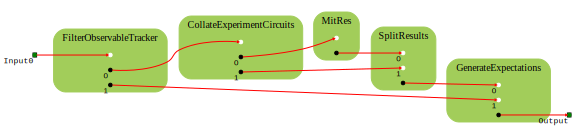

In [17]:
from qermit import MitEx

mitex = MitEx(backend)
mitex.get_task_graph()

In [18]:
result = mitex.run([experiment])
energy = sum(result[0]._dict.values()) + qpo_identity
print(f'E  = {energy:13.6f} Ha')
print(f'E0 = {cc_energy:13.6f} Ha (reference CC energy)')

E  =     -1.108424 Ha
E0 =     -1.137306 Ha (reference CC energy)


Then run the `MitEx` with noise mitigation technique.

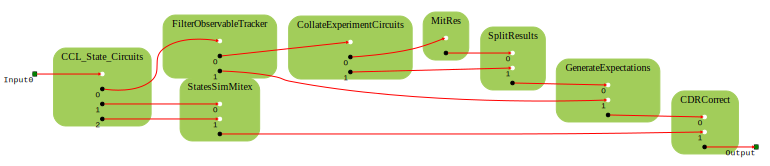

In [19]:
from qermit.clifford_noise_characterisation import gen_CDR_MitEx

cdr_mitex = gen_CDR_MitEx(device_backend=backend,
                      simulator_backend=noiseless_backend,
                      n_non_cliffords=2,
                      n_pairs=2,
                      total_state_circuits=50
)
cdr_mitex.get_task_graph()

In [20]:
# This may take some time...
result = cdr_mitex.run([experiment])
energy = sum(result[0]._dict.values()) + qpo_identity
print(f'E  = {energy:13.6f} Ha')
print(f'E0 = {cc_energy:13.6f} Ha (reference CC energy)')

E  =     -1.133449 Ha
E0 =     -1.137306 Ha (reference CC energy)
